In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from helper_fn import *
# path = os.path.join(
#     os.path.dirname(os.path.dirname(os.path.abspath(__file__))), "data/"
# )
path = "../data"
data_path = os.path.join(path, "results/")
gt_path = os.path.join(path, "GT/")

# #  get list of folders in data_path
# folders = [
#     f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))
# ]

# # parse the folder names to get the parameters
# params = [f.split("_") for f in folders]
# heads = [params[i][4] for i in range(len(folders))]
# modalities = [params[i][3] for i in range(len(folders))]

gt_tracks = []
taus = []
for i, fn in enumerate(os.listdir(gt_path)):
    track = np.load(os.path.join(gt_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

track_lengths = [track.shape[0] for track in gt_tracks]

head = "xtransformer"
modality = "bf"

tracks = get_data(path=data_path, modality=modality, head=head)
fucci_labels = ["green", "red"]


####################
# analysis of the first head
####################

# head_idx = 0
# head = heads[head_idx]
# head_folder = folders[head_idx]
# head_path = os.path.join(data_path, head_folder)
# track_filenames = os.listdir(head_path)


# # opening tracks in the first folder
# tracks = []
# for i, fn in enumerate(track_filenames):
#     track = np.load(os.path.join(head_path, fn)).squeeze().T
#     tracks.append(track)


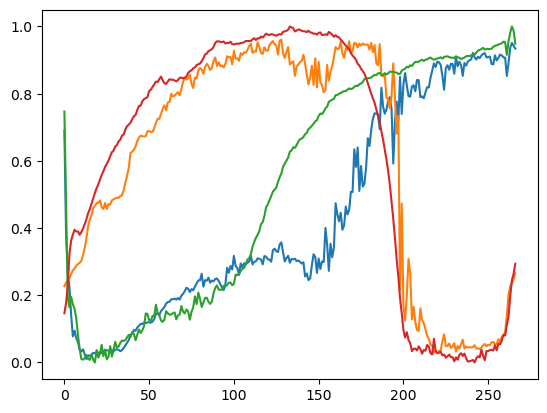

array([0.10967568, 0.07718339])

In [3]:
tracks[0].shape, gt_tracks[0].shape

tr0 = tracks[0]
gt0 = gt_tracks[0]

plt.plot(tr0)
plt.plot(gt0)
plt.show()

np.abs(tr0 - gt0).mean(axis=(0))

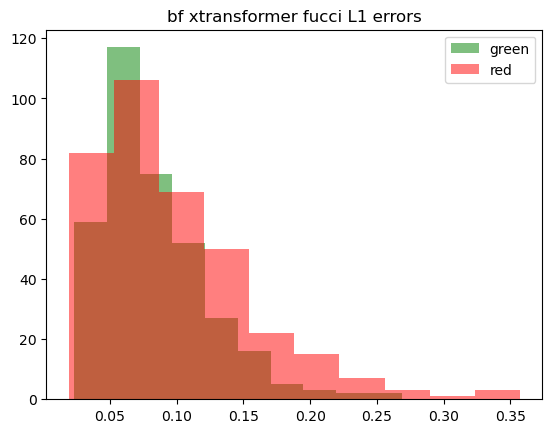

In [4]:
l1_err = mean_track_error(gt_tracks, tracks, metric="L1", av_channels=False)

fi = 0
plt.title(f"{modality} {head} fucci L1 errors")
plt.hist(l1_err[:, fi], label=fucci_labels[fi], alpha=0.5, color="green")  

fi = 1
plt.hist(l1_err[:, fi], label=fucci_labels[fi], alpha=0.5, color="red")

plt.legend()
plt.show()

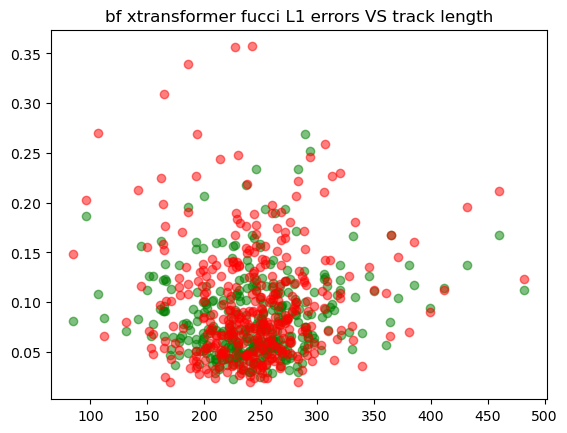

In [5]:
plt.title(f"{modality} {head} fucci L1 errors VS track length")

plt.scatter(track_lengths, l1_err[:, 0], label=fucci_labels[0], alpha=0.5, color="green")
plt.scatter(track_lengths, l1_err[:, 1], label=fucci_labels[1], alpha=0.5, color="red")

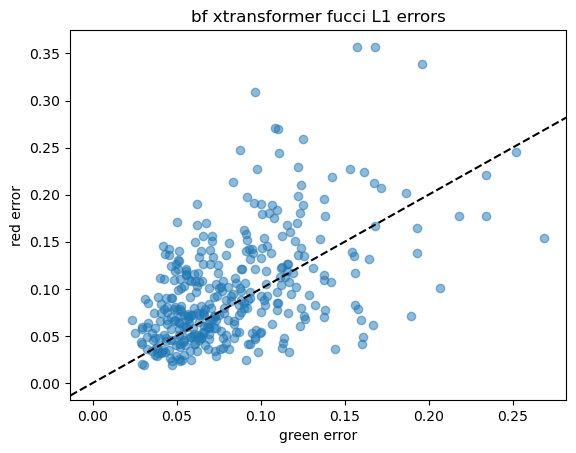

In [6]:
plt.scatter(l1_err[:, 0], l1_err[:, 1], alpha=0.5)
plt.xlabel(f"{fucci_labels[0]} error")
plt.ylabel(f"{fucci_labels[1]} error")

plt.title(f"{modality} {head} fucci L1 errors")

plt.axline([0, 0], slope=1, color="black", linestyle="--")

In [7]:
n_tracks = len(tracks)

errors_g = []
errors_r = []
for i in range(n_tracks):
    error = np.abs(tracks[i] - gt_tracks[i])
    errors_g.append(error[:, 0])
    errors_r.append(error[:, 1])
    

In [8]:
errors_g_unrolled = np.concatenate(errors_g)
errors_r_unrolled = np.concatenate(errors_r)
taus_unrolled = np.concatenate(taus)

In [9]:
import seaborn as sns

df = pd.DataFrame(
    {
        "tau": taus_unrolled,
        "error_g": errors_g_unrolled,
        "error_r": errors_r_unrolled,
        "fucci": "green",
    }
)

# # density plot taus VS errors_g
# sns.kdeplot(data=df, x="tau", y="error_g", hue="fucci", fill=True)
# plt.show()
# # density plot taus VS errors_g
# sns.kdeplot(data=df, x="tau", y="error_r", hue="fucci", fill=True)

In [ ]:
#density plot taus VS errors_g
sns.kdeplot(data=df, x="tau", y="error_r", hue="fucci", fill=True)

# log to normal

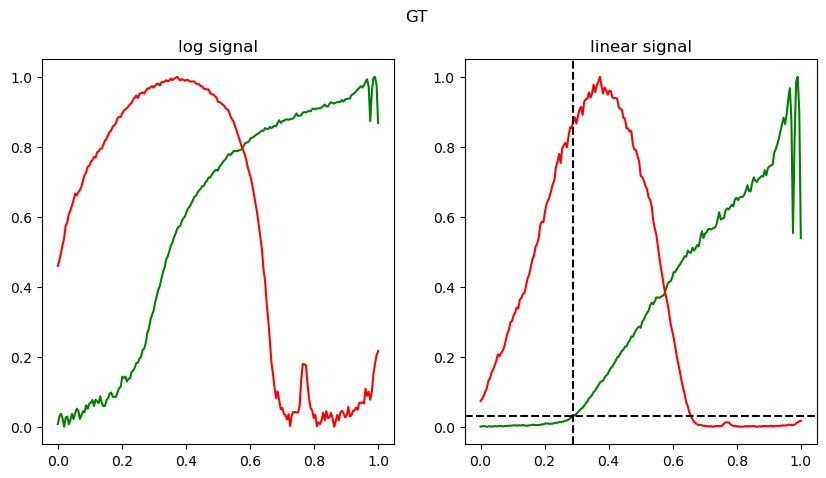

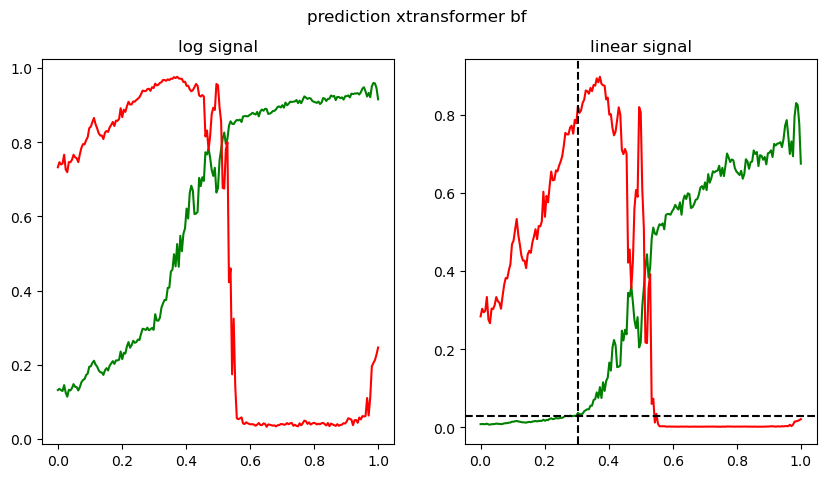

In [10]:
plt.figure(figsize=(10, 5))
plt.suptitle("GT")

idx = np.random.randint(0, n_tracks)

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], gt_tracks[idx][:,0], color="green")
plt.plot(taus[idx], gt_tracks[idx][:,1], color="red")

fuc = inverse_log_min_max(gt_tracks[idx], eps=0.01, log_base=np.e)
th = 0.03

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:,0], color="green")
plt.plot(taus[idx], fuc[:,1], color="red")

x_crossing = find_threshold_crossing(taus[idx], fuc[:,0], th)


plt.axhline(th, color="black", linestyle="--")
plt.axvline(x_crossing, color="black", linestyle="--")
plt.show()


plt.figure(figsize=(10, 5))
plt.suptitle(f"prediction {head} {modality}")

plt.subplot(1, 2, 1)
plt.title(f"log signal")
plt.plot(taus[idx], tracks[idx][:,0], color="green")
plt.plot(taus[idx], tracks[idx][:,1], color="red")

fuc = inverse_log_min_max(tracks[idx], eps=0.01, log_base=np.e)
th = 0.03

plt.subplot(1, 2, 2)
plt.title(f"linear signal")
plt.plot(taus[idx], fuc[:,0], color="green")
plt.plot(taus[idx], fuc[:,1], color="red")

x_crossing = find_threshold_crossing(taus[idx], fuc[:, 0], th)


plt.axhline(th, color="black", linestyle="--")
plt.axvline(x_crossing, color="black", linestyle="--")